# Refaire l'expèrience en utilisant des petits $\theta$ (<15°)

In [1]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio
import random
import MotionClouds as MC

In [2]:
upscale = 4
fig_width = 21
fx, fy, ft = mc.get_grids(mc.N_X*upscale, mc.N_Y*upscale, 1)

In [3]:
%mkdir -p tmp

In [4]:

def generate_random_cloud(theta, B_theta):#, upscale = 1):
    #fx, fy, ft = mc.get_grids(mc.N_X*upscale, mc.N_Y*upscale, 1)
    mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0.,
                             B_V=0, theta=theta, B_theta=B_theta)
    im = mc.random_cloud(mc_i)
    im = (mc.rectif(im) * 255).astype('uint8')
    #return im[:, :, 0]
    fname = 'tmp/%s_%s.png' % (theta, B_theta)
    imageio.imwrite(fname, im[:, :, 0])
    return fname


In [5]:
def do_experiment():
    from psychopy import visual, core, event, gui, data
    exp_name = "Perception de l'orientation"
    exp_info = {'participant':''}
    subj_info = gui.DlgFromDict(dictionary=exp_info, title=exp_name)
    exp_info['exp_name']=exp_name

    from psychopy import visual, core, event
    import MotionClouds as MC

    test_length = 150  # number of trials
    fixation_length = .5  # length of fixation, in second
    stim1_length = 0.25  # length of first stim, in second
    #stim2_length = 0.25  # length of the second stim, in second 

    std_theta = np.pi/24

    fullscr = False

    fullscr = True


    win = visual.Window(fullscr=fullscr, color=[0,0,0])#, winType='pygame', monitor='testMonitor', units='height')
    mouse = event.Mouse(visible=False)

    fixation = visual.ShapeStim(vertices='cross', win=win, size=0.05, pos=[0, 0], fillColor='black', units='height')
    fixation.autolog = False

    MC1 = generate_random_cloud(np.pi/2, B_theta=np.pi/2)
    bitmap1 = visual.ImageStim(win, MC1, mask='gauss', size=0.8, units='height')
    bitmap1.autolog = False 

    msg = visual.TextStim(win, text='?', color='black', pos=[0, 0])

    import time
    start_time = time.time()
    print("Test started")


    ans_list = []
    N_B_thetas = 3
    B_thetas = np.pi*np.logspace(-7, -3.5, N_B_thetas, base=2)

    for trial in range(test_length):
        clock = core.Clock()
        fixation.draw()
        win.flip()

        theta = std_theta * np.random.randn()

        # MC generation
        B_theta = B_thetas[random.randint(0, N_B_thetas-1)]

        im = generate_random_cloud(np.pi/2-theta, B_theta=B_theta) 
        bitmap1.setImage(im)

        # Times the trial
        while clock.getTime() < fixation_length + stim1_length: # + stim2_length:
            if 0.0 <= clock.getTime() < fixation_length:  # fixation
                fixation.draw()
            if fixation_length + 0.01 <= clock.getTime() < fixation_length + stim1_length: 
                bitmap1.draw()
                win.flip()
            #if fixation_length + stim1_length <= clock.getTime() < fixation_length + stim1_length + stim2_length:
            #    msg.draw()

        win.flip()

        while True:
            ans = event.waitKeys()
            if ans == ['escape', 'q']:
                win.close()
                core.quit()
            elif ans[0] in ['left', 'right']:
                correct = (np.sign(theta) > 0) and (ans[0]=='right')
                print('At trial ', trial, 'Angle=', '%3.3f' % (theta*180/np.pi), 'answer is ',
                    ans[0], '(correct=', correct, '); bandwidth=', '%.3f' % (B_theta*180/np.pi))    
                break

        # Output shape per trial is : trial number, shift direction, answered shift and b_theta
        ans_list.append([trial, theta, ans[0], B_theta])

    win.close()

    import pickle
    pickle.dump(ans_list, open('Psychophys_discrim_%s.p' % exp_info['participant'], 'wb'))
    #on sauve nos superbes données

In [8]:
# do_experiment()

# analyse

In [6]:
import pickle
import matplotlib.pyplot as plt

subj_name_list =  ['JF4','JF5','JF6']
subj_data_list = []
subj_name_list =  ['LP1']

for subject in subj_name_list :
    x = pickle.load(open(r'Psychophys_discrim_%s.p'%subject, 'rb'))

    #pickle.load,charge le contenu du fichier B_theta dans x
    
    subj_data_list.append(x)

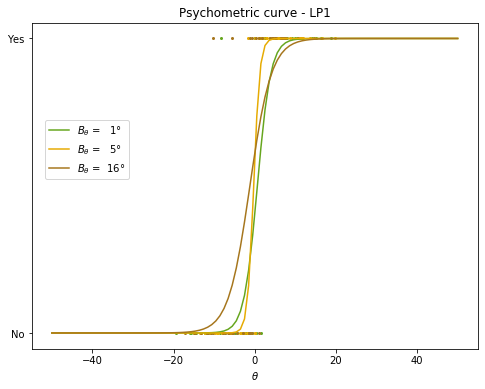

In [7]:
from sklearn.linear_model import LogisticRegression
import numpy as np
from matplotlib.pyplot import cm

x_values = np.linspace(-50, 50, 100)
x_plot = np.reshape(x_values, (100,1))
lr_kwargs = dict(solver='liblinear', C = 3, max_iter=1000, penalty='l2', class_weight = {1 : 1 , 0 : 1})


b_thetas_list = []
for x in subj_data_list[0] :
    b_thetas_list.append(x[3]*180/np.pi)
b_thetas_list = sorted(set(b_thetas_list))

coef_list = []

for num, subj_data in enumerate(subj_data_list) :
    color = iter(cm.Dark2(np.linspace(.5, 1,5)))
    plt.figure(figsize = (8,6)) 
    for ibtheta, b_theta in enumerate(b_thetas_list):
        X = []
        y = []

        for i in subj_data :
            if i[3]*180/np.pi == b_theta :
                X.append(i[1]*180/np.pi)
                if  i[2] == 'right':  
                        y.append(1)
                else :
                        y.append(0)
      
        X = np.asarray(X)
        X = X[:,np.newaxis]
        col = next(color)
    
        lgs = LogisticRegression(**lr_kwargs)
        try :
            lgs.fit(X, y)
            coef_list.append((b_theta,lgs.coef_[0][0]))
        
            y_values = lgs.predict_proba(x_plot)[:,1]
            plt.plot(x_values, y_values, label = r'$B_\theta$ = %3.f°' %b_theta,color = col)
            plt.scatter(X, y, s=4, color = col)
        except :
            pass
            
    plt.title('Psychometric curve - %s' % subj_name_list[num])
    plt.xlabel(r'$\theta$')
    plt.yticks([0.,1.],['No', 'Yes'])
    plt.legend(loc = (0.03, 0.52)) 
    plt.show